<div style="background-color: #002676; padding: 20px;">
<img src="https://macss.berkeley.edu/wp-content/uploads/2023/09/UCBMaCSS_Logo_2Color_Reverse_TaglineB.png" alt="MaCSS" width="300">
</div>

# **Notebook 4:** Data Analysis

[wdtmacss@berkeley.edu](mailto:wdtmacss@berkeley.edu)\
**Computational Social Science 1A**\
[Human Psychology and Social Technologies](https://classes.berkeley.edu/content/2024-fall-compss-214a-001-lec-001) 
Fall 2024\
UC Berkeley [Masters in Computational Social Science](https://macss.berkeley.edu/about/)

**Week 4:** Performing regressions and DiD analyses in Python.

👩🏾‍🔬🧑‍💻👩🏻‍💻👨🏿‍💻🔬

---

# Table of Contents
1. [Announcements](#announcements)
2. [Summary of Today's Class](#summary-of-todays-class)
3. [Data Simulation](#data-simulation)
    - [Employee Satisfaction Parameters](#employee-satisfaction-parameters)
    - [Time Window Parameters](#time-window-parameters)
    - [Treatment Effect Parameters](#treatment-effect-parameters)
    - [Simulation Loop](#simulation-loop)
4. [Data Analysis](#data-analysis)
    - [Regressions in Python: Some Basics](#regressions-in-python-some-basics)
    - [Outcome Variable: Employee Satisfaction](#outcome-variable-employee-satisfaction)
    - [Categorical Predictor: Company](#categorical-predictor-company)
    - [Continuous Predictor: Time at Company](#continuous-predictor-time-at-company)
    - [Multiple Predictors](#multiple-predictors)
    - [Difference in Differences Analysis](#difference-in-differences-analysis)
        - [Dummy Variables](#dummy-variables)
        - [Interaction Term](#interaction-term)
5. [Data Analysis Challenge 1: Treatment Effect](#data-analysis-challenge-1-treatment-effect)
6. [Data Analysis Challenge 2: Baseline Satisfaction Levels](#data-analysis-challenge-2-baseline-satisfaction-levels)
7. [Assignment Two](#assignment-two)


---

# Announcments
*  **Class structure updates**
    * Only two weeks remaining:
        * previous plan to do a second big dataset seems too rushed now;
        * unfair to request a DiD Twitter analysis assignment this week
    * New schedule structure: focus **entirely on the Twitter dataset**
    * New assignment structure:
        * the twitter analysis is now your **class project**, due at the end of the class
        * we'll have a **scaffolding assignment** before then, on data simulation and analysis of the simulated dataset, designed to really prepare you for DiD analysis before your class project
* **Updated Schedule**:
  * today (data analysis practical session: regression & DiD)
  * next week: scaffolding asignment due (Thursday), class project lab 1 (friday)
  * final week: class project lab 2, plus class discussion of social media perspective papers, farewell cupcackes 🧁🧁
* These updates are captured in the [updated class syllabus](https://bcourses.berkeley.edu/courses/1538139/files/89784577?wrap=1)
*  Questions?

# Summary of Today's Class
The goal today is to build confidence around basic aspects of regression analysis in python, and to develop and understanding of and capacity to implement DiD analysis using regression.  

**Today we will:** 
*  Simulate data using the code we developed last week
*  Perform regression analyses on the simulated data
*  Perform DiD analyses on the simulated data
  

# Data Simulation
Below we will simulate a dataset using the code we developed last week. See `notebook-3-data-simulation.ipynb` for more information on the simulation process and its motivations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Employee Satisfaction Parameters

In [3]:
def employee_satisfaction(satisfactions=[5.2, 6.1], num_employees_per_company=[50,50]):
    # Mean employee_satisfaction levels for both companies
    company_profiles = {
        "Rubicon": {
            "employee_satisfaction": satisfactions[0], # satisfaction on a scale of 1 to 10
            "employee_num": num_employees_per_company[0]
        },
        "Giggle": {
            "employee_satisfaction": satisfactions[1], # satisfaction on a scale of 1 to 10
            "employee_num": num_employees_per_company[1]
        },
    }
    return company_profiles

company_profiles = employee_satisfaction()

## Time window parameters

In [12]:
def generate_dates(frequency='W'):
    # Define a data collection time window
    data_collection_start_date = pd.to_datetime("2022-01-01")
    data_collection_end_date = pd.to_datetime("2023-12-31")

    # Create an array of dates on which to simulate collection of satisfaction data
    dates = pd.date_range(
        start=data_collection_start_date, 
        end=data_collection_end_date, 
        freq=frequency # weekly intervals between start and end
    )
    return dates, data_collection_start_date, data_collection_end_date

dates, data_collection_start_date, data_collection_end_date = generate_dates()
dates

DatetimeIndex(['2022-01-02', '2022-01-09', '2022-01-16', '2022-01-23',
               '2022-01-30', '2022-02-06', '2022-02-13', '2022-02-20',
               '2022-02-27', '2022-03-06',
               ...
               '2023-10-29', '2023-11-05', '2023-11-12', '2023-11-19',
               '2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17',
               '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', length=105, freq='W-SUN')

## Treatment effect parameters

In [5]:
remote_work_onset_date = pd.to_datetime("2023-01-01")

## Simulation loop

In [15]:
# create an empty list to store our simulated data
def create_company_profiles(remote_work_treatment_effect=2, frequency='W', satisfactions=[5.2, 6.1], satisfaction_variance=1, onset_date='2023-01-01', num_employees=[50,50]):
    dates, data_collection_start_date, data_collection_end_date = generate_dates(frequency)

    company_profiles = employee_satisfaction(satisfactions, num_employees)

    remote_work_onset_date = pd.to_datetime(onset_date)

    num_employees_per_company = 50

    data = []

    # iterate over the company_profiles
    for company, profile in company_profiles.items():
        mean_satisfaction = profile["employee_satisfaction"]
        num_employees_per_company = profile["employee_num"]

        # print(f"Simulating {company} Data")
        
        # iterate over the date range
        for date in dates:
            time_at_company = (date - data_collection_start_date).days # this is new
            # iterate over the number of employees
            for i in range(num_employees_per_company):
                
                # sample an initial satisfaction level 
                # by using the company average and adding noise 
                satisfaction = mean_satisfaction + np.random.normal(0, satisfaction_variance)
                
                # add in the treatment effect
                if date > remote_work_onset_date:
                    if company == "Giggle":
                        satisfaction += remote_work_treatment_effect 
                
                # create the datapoint for our dataset
                datapoint = {
                    "date": date, 
                    "company": company,
                    "satisfaction": satisfaction,
                    "employee_id": f"{company[0]}{i}", # create a fake employee id by combining the company name initial letter and the loop index variable
                    "time_at_company": time_at_company
                } 
                data.append(datapoint)
    return pd.DataFrame(data)

df = create_company_profiles()
df.sample(n=10)

,date,company,satisfaction,employee_id,time_at_company
5890,2022-03-27,Giggle,5.220617,G40,85
4097,2023-07-23,Rubicon,6.452990,R47,568
4159,2023-08-06,Rubicon,4.855349,R9,582
6096,2022-04-24,Giggle,6.194894,G46,113
9957,2023-10-22,Giggle,7.384206,G7,659
328,2022-02-13,Rubicon,5.900497,R28,43
3906,2023-07-02,Rubicon,5.164429,R6,547
923,2022-05-08,Rubicon,5.332975,R23,127
6079,2022-04-24,Giggle,5.820631,G29,113
3016,2023-02-26,Rubicon,3.497487,R16,421


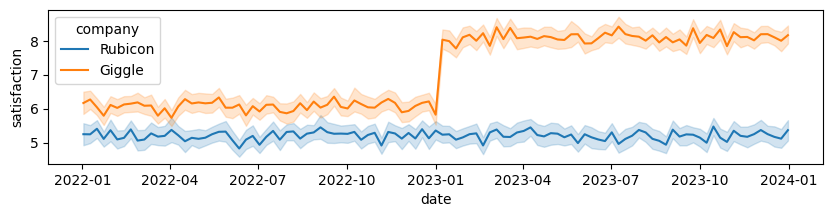

In [16]:
def plot_did(remote_work_treatment_effect=2, frequency='W', satisfactions=[5.2, 6.1], satisfaction_variance=1, onset_date='2023-01-01', num_employees=[50,50]):
    df = create_company_profiles(remote_work_treatment_effect, frequency, satisfactions, satisfaction_variance, onset_date, num_employees)

    plt.figure(figsize=(10, 2)) # make the figure size wide (10) and shallow (2)

    sns.lineplot(data=df, x="date", y="satisfaction", hue="company")

    plt.show()

plot_did()

# Data Analysis

## Regressions in Python: some basics
We'll use the [statsmodels](https://www.statsmodels.org/stable/index.html) library to analyze regression models. Statsmodels is nicer than alternatives because it let's you do regressions in python using the same formulae-based approach that is common in R packes such as `lmer`. 

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Outcome variable: employee satisfaction
We're going to try to predict `satisfaction`.

### Categorical predictor: company
First, let's try to predict `satisfaction` from `company`. 

We will express our model using a formula. The structure of the formula is: `dependent variable ~ independent variable`. Here, the tilde sign `~` seperates the outcome (dependent variable, left hand side -- the thing we are trying to predict) from the predictors (independent variable, right hand side). 

In concrete terms, we're trying answer the question: **did employees at the two different companies have different levels of satisfaction?** Since we generated the data ourselves, we know the true answer! 

For this analysis, our formula is:

In [18]:
regression_formula = 'satisfaction ~ company'

We create our model by passing our datset and the formular to statmodels as follows:

In [19]:
model = smf.ols(regression_formula, data=df)

Now that the model is specified, we can *fit* the model to the data as follows:

In [20]:
results = model.fit()

Let's look at the results. I will explain the table in cells below.

In [21]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     6285.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:31:03   Log-Likelihood:                -16977.
No. Observations:               10500   AIC:                         3.396e+04
Df Residuals:                   10498   BIC:                         3.397e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.0989      0

In [22]:
def model_summary(remote_work_treatment_effect=2, frequency='W', satisfactions=[5.2,6.1], satisfaction_variance=1, onset_date='2023-01-01', num_employees=[50,50]):
    df = create_company_profiles(remote_work_treatment_effect, frequency, satisfactions, satisfaction_variance, onset_date, num_employees)

    df['post_treatment'] = (df['date'] > remote_work_onset_date).astype(int)
    df['treatment_group'] = (df['company'] == 'Giggle').astype(int)
    formula = 'satisfaction ~ post_treatment + treatment_group + post_treatment*treatment_group'
    model = smf.ols(formula, data=df).fit()
    print(model.summary())

model_summary()

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     5089.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:31:07   Log-Likelihood:                -14792.
No. Observations:               10500   AIC:                         2.959e+04
Df Residuals:                   10496   BIC:                         2.962e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### Interpreting the results table 👀
How does this table help us answer the question? The key section is the middle row, which shows *coefficient estimates* and assosciated statistics. 

#### Coeficient estimates
Here the relevant coeficient estimate is the coeficient for `company`. Recall that the basic purpose of a regression analysis is to estimate the coeficients $w_i$ in an equation of the form:
$$y = x_1 w_1, \ldots, x_n w_n$$
where $x_1,\ldots,x_n$ are predictor variables and $y$ is the outcome variable.  

When we look at the table above, the coefficient estimates are giving us the model's best guess at the $w_i$ terms. So:

*  If the coeficient estaimte for the relevant variable (`company`) is zero, that would tell us that this variable is not predictive of the outcome variable (`satisfaction`), because zero multiplied by anything is equal to zero and therefore **the predictor doesn't influence the outcome** $y$ (here `satisfaction`).
*  If the **coeficient estimate is positive**, that would tell us that the company variable had a positive effect on the outcome variable (i.e. increased `satisfaction`)
    *  **Note**: in the case of binary categorical predictors (`Giggle` vs `Rubicon`), there is generally assumed to be one *reference* class, and the coeficient tells us about the effect of the other class.
    *  Here, the reference class is `Giggle`, and the coeficient tells us about the effect of `Rubicon`. We can see that because the `company` variable in the table states `[T.Rubicon]`
*  If the **coeficient estimate was negative**, we would conclude that the variable had a negative impact relative the the reference class, i.e. working at `Rubicon` is assosciated with a decrease in employee satisfaction relative to `Giggle`.

#### Statistical Significance
You can also look at the colum `P>|t|` to underestand the statistical significance. 

If your alpha value for decidiing statistical statistical significance is `0.05`, you would look at the value in the `P>|t|` column and see if it is **smaller than `0.05`** on the relevant row. If you observe a regression coefficient estimate that is statistically significiantly different than zero, you can conclude that the variable has an effect on `satisfaction` in this dataset. The direction of the effect is given by the sign of the coefficient estimate (`-` or `+`). The magnitude of the effect is a complicated quantity, but is related to the absolute value of the coefficient estimate.

**What does the results table above indicate?**

### Continuous predictor
Let's look at a continuous predictor variable: `time_at_company`. Here, we're actually looking at a **spurious** predicter variable! We know that `time_at_company` is not itself directly causally related to `satisfaction` in a simple way, because we created the data!  

In [23]:
regression_formula = 'satisfaction ~ time_at_company'

In [24]:
model = smf.ols(regression_formula, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     883.3
Date:                Fri, 27 Sep 2024   Prob (F-statistic):          1.96e-186
Time:                        14:31:14   Log-Likelihood:                -19017.
No. Observations:               10500   AIC:                         3.804e+04
Df Residuals:                   10498   BIC:                         3.805e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.4172      0.029    1

**What do these results indicate?** Does the regression suggest an effect of `time_at_company` on `satisfaction`? If so, why?

### Mulitple predictors
You can include multiple predictors in the model using the formula syntax: `dependent_variable ~ indepdent_variable_1 + independent_variable_2 + ...`.

In [25]:
regression_formula = 'satisfaction ~ company + time_at_company'

In [26]:
model = smf.ols(regression_formula, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     4331.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:31:23   Log-Likelihood:                -16282.
No. Observations:               10500   AIC:                         3.257e+04
Df Residuals:                   10497   BIC:                         3.259e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.3603      0

**What do these results indicate?** The results of these analyses can be a little unsatisfying or even misleading. This is because the true process that generated the data involves the onset of remote work in our simulation, and this variable has not been included so far. In the next section, we will see how you can isolate the effects of the remote work intervention through the inclusion of an interaction term in the model, implementing a Difference in Differences analysis.

## Difference in Differences Analysis

### Dummy variables

To perform a Difference in Differences analyses that accounts for the onset of a treatment that was applied to one group but not the other, we need to create two binary variables. 

The first binary variable captures **whether the datapoint is before (`0`) or after (`1`) the onset of the treatment**. We can use the `remote_work_onset_date` variable to code this, utilizing the datetime functionality of the `date` column as follows:

In [27]:
df['post_treatment'] = (df['date'] > remote_work_onset_date).astype(int)

The second binary variable captures **whether the employee belongs to the company that offered remote work**. Or in more generic terms, whether the row reflects the group that received the treatment (`1`) or not (`0`). 

In [28]:
# Create the treatment_group variable
df['treatment_group'] = (df['company'] == 'Giggle').astype(int)

In [29]:
df.sample(10)

,date,company,satisfaction,employee_id,time_at_company,post_treatment,treatment_group
65,2022-01-09,Rubicon,4.349441,R15,8,0,0
3126,2023-03-12,Rubicon,4.965405,R26,435,1,0
7422,2022-10-30,Giggle,6.478546,G22,302,0,1
6055,2022-04-24,Giggle,5.182085,G5,113,0,1
4722,2023-10-22,Rubicon,6.501795,R22,659,1,0
7072,2022-09-11,Giggle,6.048199,G22,253,0,1
9623,2023-09-03,Giggle,9.244632,G23,610,1,1
3038,2023-02-26,Rubicon,4.589011,R38,421,1,0
10022,2023-10-29,Giggle,5.842328,G22,666,1,1
10220,2023-11-26,Giggle,8.162039,G20,694,1,1


Together, these two variables can be combined to isolate the effect of the treatment, by incoroporating their *interaction* in the model.

### Interaction Term
Finally, we need to create an interaction term to add to our regression model. An interaction just means that two variables are *multiplied* together. In the case of two binary variables, this means that the resulting product is `1` only if both variables are `1`, and `0` otherwise. 

Here's the regression model we will consider:

*  Dependent variable (outcome): `satisfaction`
*  Independent variable (predictor) 1: `post_treatment`
*  Independent variable (predictor) 2: `treatment_group`
*  Independent variable (predictor) 3: the **interaction** between `post_treatment` and `treatment_group`. The syntax for an interaction term is `post_treatment*treatment_group`.

**Why does the interaction term capture the treatment effect?** Because only the group who received the treatment (remote work) will be coded as `1` under the interaction term.  

So our model formula is:

In [25]:
formula = 'satisfaction ~ post_treatment + treatment_group + post_treatment*treatment_group'

And now we can fit our model:

In [26]:
model = smf.ols(formula, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4819.
Date:                Thu, 26 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:38:40   Log-Likelihood:                -14908.
No. Observations:               10500   AIC:                         2.982e+04
Df Residuals:                   10496   BIC:                         2.985e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

**How do you interpret these results?**

## Data Analysis Challenge 1: treatment effect
Regenerate the dataset with **different levels of treatment effect** (the impact of remote work). Change the relevant variable, re-reun the data simulation and analysis, and examine whether the regression results accurately reflect the true effect size. Try making the treatment effect:
*   Stronger
*   Weaker
*   Negative
*   Null (i.e. no effect)

Examine the consequences in the regression results. 

In [30]:
model_summary(remote_work_treatment_effect=4)

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                 1.420e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:05:51   Log-Likelihood:                -14948.
No. Observations:               10500   AIC:                         2.990e+04
Df Residuals:                   10496   BIC:                         2.993e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [31]:
model_summary(remote_work_treatment_effect=1)

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     2137.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:06:11   Log-Likelihood:                -14876.
No. Observations:               10500   AIC:                         2.976e+04
Df Residuals:                   10496   BIC:                         2.979e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [32]:
model_summary(remote_work_treatment_effect=-2)

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     1685.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:06:17   Log-Likelihood:                -14952.
No. Observations:               10500   AIC:                         2.991e+04
Df Residuals:                   10496   BIC:                         2.994e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [33]:
model_summary(remote_work_treatment_effect=0)

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     718.5
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:06:22   Log-Likelihood:                -14849.
No. Observations:               10500   AIC:                         2.971e+04
Df Residuals:                   10496   BIC:                         2.974e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

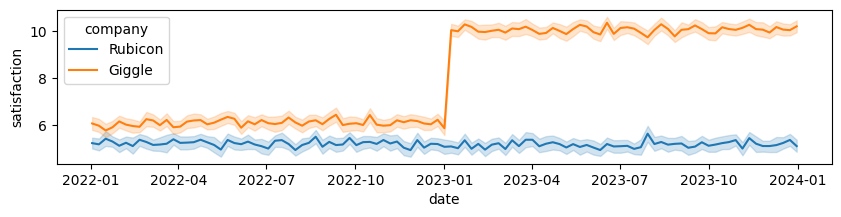

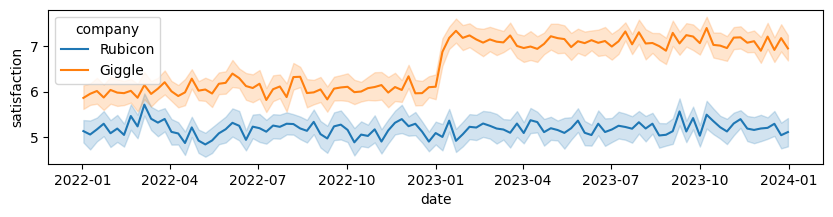

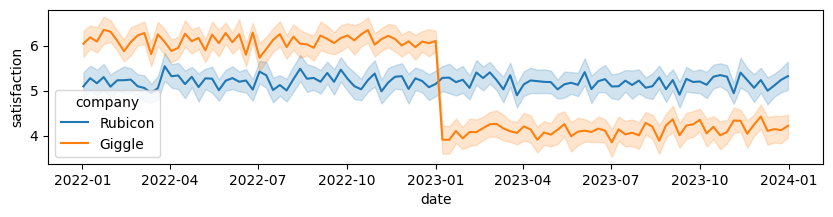

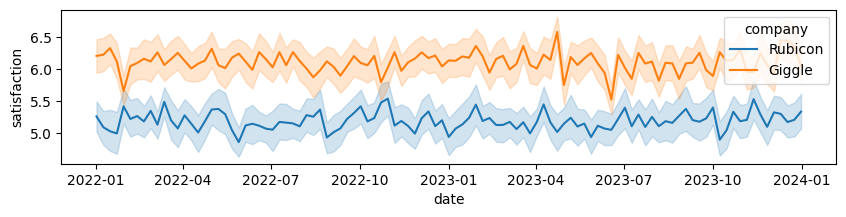

In [10]:
plot_did(remote_work_treatment_effect=4)

plot_did(remote_work_treatment_effect=1)

plot_did(remote_work_treatment_effect=-2)

plot_did(remote_work_treatment_effect=0)

## Data Analysis Challenge 2: baseline satisfaction levels
Edit the **baseline levels of saisfaction** for the two companies. Regenreate the datset a few times with larger or smaller differences in average satisfaction (in the company profiles). Is the regression analysis able to pick up the true effect size of the treatment in a way that is robust to these differences? Can the regression accurately detect the underlying differences in average saistifaction? 

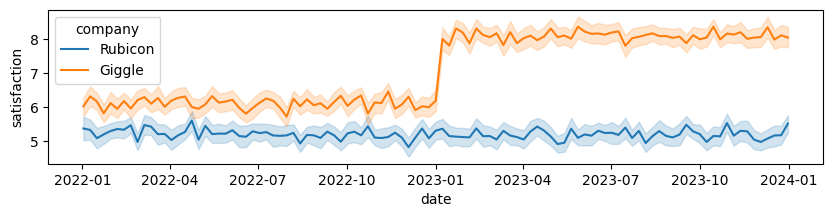

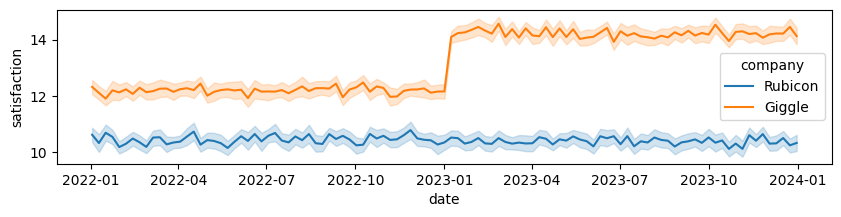

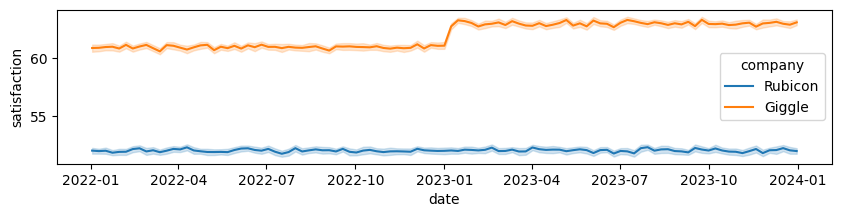

In [11]:
plot_did(satisfactions=[5.2, 6.1])

plot_did(satisfactions=[10.4, 12.2])

plot_did(satisfactions=[52, 61])

---
# Assignment Two
Assignment two is closely related to the skills and exercises we have covered today in this lab. It is designed to scaffold your understanding of regressions and DiD analyses so that you are prepared to apply these skills in your class project. 

Download and complete the **assignment two notebook** and submit via gradescope **by 10/03/2024 (Thursday next week before midnight Pacific time)**.